# Figure 2 - SARS-CoV Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import scanpy as sc
import scirpy as ir

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PolyCollection

## Settings

In [2]:
TEXT_WIDTH = 6.7261  # in
DPI = 360

In [3]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [4]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6) #todo make bigger

## Load Data

### UMAPs

In [5]:
path_ad = '../results/fig2_haniffa_lv.h5ad'
adata = sc.read(path_ad)

In [6]:
palette_leiden = adata.uns['leiden_moe_cd8te_colors']
palette_leiden = dict(zip(adata.obs['leiden_moe_cd8te'].value_counts().index, palette_leiden))
palette_leiden['-99'] = 'lightgray'

In [7]:
#sc.tl.rank_genes_groups(adata, groupby='Site', key_added='deg_test', n_genes=20)

In [8]:
def transform_status(name):
    if 'LPS' in name: 
        return 'LPS'
    return name

adata.obs['Status_on_day_collection_summary'] = adata.obs['Status_on_day_collection_summary'].apply(transform_status)

In [9]:
cp_ct = sb.color_palette('pastel')
cp_ct2 = sb.color_palette('bright')

palette_celltype = {
    'CD8.TE': cp_ct[3],
    'CD4.IL22': cp_ct[0],
    'CD8.Naive': cp_ct[1],
    'CD4.Naive': cp_ct[2],
    'CD8.EM': cp_ct[4],
    'CD4.CM': cp_ct[5],
    'CD4.Tfh': cp_ct[6],
    'CD4.EM': cp_ct[7],
    'CD8.Prolif': cp_ct2[0],
    'Treg': cp_ct2[1],
    'CD4.Th1': cp_ct2[2],
    'CD4.Prolif': cp_ct2[4],
    'CD4.Th2': cp_ct2[5],
    'CD4.Th17': cp_ct2[6],
}


cp_st = sb.color_palette('deep')
palette_status = {
    'Healthy': cp_st[2],
    'Asymptomatic': cp_st[8],
    'Mild': cp_st[1],
    'Moderate': cp_st[6],
    'Severe': cp_st[3],
    'Critical': cp_st[5],
    'Non_covid': cp_st[9],
    'LPS': cp_st[0],
}
order_status = palette_status.keys()
order_ct = ['CD8.Naive', 'CD8.Prolif', 'CD8.EM', 'CD8.TE', 
            'CD4.Naive', 'CD4.Prolif', 'CD4.CM', 'CD4.EM', 
            'CD4.IL22', 'CD4.Tfh', 'CD4.Th1', 'CD4.Th2', 'CD4.Th17', 'Treg']


In [10]:
palette_query = {
    'SARS-CoV': 'tab:red', 
    'Influenza': 'tab:blue', 
    'Human Herpesvirus': 'tab:green', 
    'Yellow Fever': 'tab:purple', 
    'Others': 'tab:olive',
    'No Match': 'lightgrey' 
}

In [11]:
color_covid_clusters = 'maroon'
color_bystander_clusters = 'navy'

In [12]:
react_leiden = adata.uns['reactive_clusters']
df_status = adata[adata.obs['leiden_moe_cd8te'].isin(react_leiden)].obs[['leiden_moe_cd8te', 
                                                                         'Status_on_day_collection_summary']]
df_status = df_status.value_counts().unstack()
df_status.head()

Status_on_day_collection_summary,Asymptomatic,Critical,Healthy,LPS,Mild,Moderate,Non_covid,Severe
leiden_moe_cd8te,,,,,,,,
3,NaN,49.0,NaN,1.0,28.0,829.0,NaN,160.0
5,NaN,63.0,4.0,1.0,46.0,706.0,1.0,176.0
6,1.0,79.0,7.0,1.0,216.0,397.0,3.0,285.0
12,NaN,10.0,2.0,NaN,31.0,46.0,NaN,605.0
14,1.0,1.0,3.0,NaN,3.0,637.0,1.0,7.0


In [13]:
df_disease = adata.uns['disease_by_leiden'].copy()
#df_disease = df_disease.div(df_disease.sum(axis=1), axis=0)
num_cells = adata[adata.obs['leiden_moe_cd8te'].isin(adata.uns['reactive_clusters'])
                                      ].obs['leiden_moe_cd8te'].value_counts().values
df_disease = df_disease.div(num_cells, axis=0)
df_disease['No Match'] = 1 - np.nansum(df_disease.values, axis=1)
df_disease = df_disease.replace(np.nan, 0)
df_disease.head()

,SARS-CoV,Influenza,Human Herpesvirus,Yellow Fever,Others,No Match
3,0.112465,0.000937,0.099344,0.002812,0.002812,0.781631
5,0.127382,0.068205,0.169509,0.092277,0.032096,0.510532
6,0.122346,0.000000,0.079879,0.026289,0.007078,0.764408
12,0.054755,0.000000,0.020173,0.011527,0.005764,0.907781
14,0.033691,0.001531,0.030628,0.006126,0.000000,0.928025


In [14]:
order_disease = ['SARS-CoV', 'Influenza', 'Human Herpesvirus', 'Yellow Fever', 'Others', 'No Match']

## Plot Image

### Umaps

In [15]:
def plot_umap(adata, grouping, ax, legend=None, ylabel=None, xlabel=None, embedding='moe', order=None):
    xy = adata.obsm[f'X_umap_{embedding}']
    colors = adata.obs[grouping].values
    
    palette = None
    if grouping == 'ifn response_score':
        palette = 'viridis'
        vmin, vmax = np.percentile(adata.obs['ifn response_score'], [1, 99])
        colors = np.clip(colors, vmin, vmax)
    if grouping == 'leiden_moe_cd8te':
        colors = [el if type(el)==str else '-99' for el in colors]
        palette = palette_leiden
    if grouping == 'full_clustering':
        palette = palette_celltype
    if grouping == 'Status_on_day_collection_summary':
        palette = palette_status
    
    plot = sb.scatterplot(x=xy[:, 0], y=xy[:, 1], ax=ax, hue=colors, 
                          s=0.05, linewidth=0, palette=palette)

    ax.grid(False)
    sb.despine(ax=ax, left=True, bottom=True)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
    if legend is not None:
        pos = (1.4, 0.9)
        if legend == 'upper left':
            pos = (-0.3, 0.9)
        
        handles, labels = ax.get_legend_handles_labels()
        label_dict = dict(zip(labels, handles))
        ax.legend([label_dict[o] for o in order], order, 
                  markerscale=0.5, fontsize='xx-small', loc=legend, frameon=False,
                  bbox_to_anchor=pos, #(1.5, 0.5), 
                  bbox_transform=ax.transAxes)

    else:
        ax.legend([], [], frameon=False)
    
    if ylabel is not None:
        ax.text(0, 0.5, ylabel, size='large', rotation=90, 
                verticalalignment='center', horizontalalignment='right', transform=ax.transAxes)
    if xlabel is not None:
        ax.text(0.5, 1., xlabel, size='large', 
                verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes)

In [16]:
def plot_umap_axis(ax, offset=0):
    ax.arrow(x=0.09-offset, y=0.07-offset, dx=0, dy=0.17, color='black', width=0.001,
             head_width=0.02, head_length=0.02, clip_on=False,
             length_includes_head=True, zorder=1, transform=ax.transAxes) 
    ax.arrow(x=0.09-offset, y=0.07-offset, dx=0.16, dy=0, color='black', width=0.001, 
             head_width=0.02, head_length=0.02, clip_on=False,
             length_includes_head=True, zorder=1, transform=ax.transAxes) 
    ax.text(0.07-offset, 0-offset, 'UMAP1', size='x-small', transform=ax.transAxes)
    ax.text(0.01-offset, 0.07-offset, 'UMAP2', size='x-small', rotation=90, transform=ax.transAxes)

In [17]:
def plot_colorbar(adata, gene, ax):
    palette = 'viridis'
    colors = adata.obs[gene].values
    
    vmin, vmax = np.percentile(adata.obs[gene], [1, 99])
    colors = np.clip(colors, vmin, vmax)
    norm = plt.Normalize(colors.min(), colors.max())
    
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])

    plt.colorbar(sm, label=None, cax=ax)
    ax.grid(False)
    #sb.despine(ax=ax, left=True, bottom=True)

### Other plots

In [18]:
def plot_violin(data, col, ax):
    df = data.obs[[col, 'leiden_moe_cd8te']]
    plot = sc.pl.violin(data, keys=col, groupby='leiden_moe_cd8te', size=0.1, linewidth=0.3,
                        palette=palette_leiden,
                        ax=ax, show=False)
    
    ps_ifn = data.uns['p_values_ifn']
    xticks = [el.replace('\n', ' ') for el in ps_ifn['cluster+sign'].values]
    labels = plot.set_xticklabels(xticks)
    
    for l, v in zip(labels, plot.findobj(PolyCollection)):
        if '***' in l.get_text():
            #l.set_fontweight()
            v.set_linewidth(0.8)
        else:
            # v.set_edgecolor('lightgrey')
            v.set_alpha(0.5)
            v.set_color('lightgrey')
    
    ax.tick_params(axis='x', labelrotation=270, labelsize='x-small')
    plot.set_ylabel('IFN response')
    plot.set_xlabel('CD8-TE cluster')
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.labelpad = 0
    ax.xaxis.labelpad = 2
    ax.tick_params(axis='y', which='major', pad=0)
    ax.tick_params(axis='x', which='major', pad=-2)

In [19]:
def plot_stacked_bar(df, title, ylabel, palette, ax, legend=False, order=None, cv_clusters=None, by_clusters=None):
    df = df.div(df.sum(axis=1), axis=0)
    plot = df.plot(kind='bar', stacked=True, color=palette,  ax=ax)
    ax.set_title(title, pad=12)
    ax.set_xlabel('CD8-TE cluster')
    ax.set_ylabel(ylabel)
    
    if legend:
        handles, labels = ax.get_legend_handles_labels()
        label_dict = dict(zip(labels, handles))
        ax.legend([label_dict[o] for o in order], order,
                  markerscale=0.5, fontsize='x-small', ncol=len(df.columns)//2, loc='upper center', bbox_to_anchor=(0.5, 1.2),
                  frameon=False)
    else:
        ax.get_legend().remove()
    ax.tick_params(axis='x', labelrotation=0)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.labelpad = 1
    ax.xaxis.labelpad = 1
    ax.tick_params(axis='y', which='major', pad=0)
    ax.tick_params(axis='x', which='major', pad=0)
    
    for tick in ax.get_xticklabels():
        if cv_clusters is not None and tick.get_text() in cv_clusters:
            tick.set_color(color_covid_clusters)
            tick.set_weight('bold')
        if by_clusters is not None and  tick.get_text() in by_clusters:
            tick.set_color(color_bystander_clusters)
            tick.set_weight('bold')
    

In [20]:
def plot_days(data, grouping, ax, cv_clusters=None, by_clusters=None):
    react_leiden = data.uns['reactive_clusters']
    df = data[data.obs['leiden_moe_cd8te'].isin(react_leiden)].obs
    plot = sb.violinplot(data=df, x='leiden_moe_cd8te', y=grouping, ax=ax, color='yellowgreen', scale='width', 
                         inner=None)
    # sb.stripplot(data=df, x='leiden_moe_cd8te', y=grouping, color='b', ax=ax, size=0.5)
    
    new_width = 0.5
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_width
        patch.set_width(new_width)
        patch.set_x(patch.get_x() + diff * .5)
    
    ax.set_title('Disease progression', pad=0)
    ax.set_xlabel('CD8-TE cluster')
    ax.set_ylabel('Days from onset')
    
    ax.tick_params(axis='x', labelrotation=0)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.labelpad = 1
    ax.xaxis.labelpad = 1
    ax.tick_params(axis='y', which='major', pad=0)
    ax.tick_params(axis='x', which='major', pad=0)
    for tick in ax.get_xticklabels():
        if cv_clusters is not None and tick.get_text() in cv_clusters:
            tick.set_color(color_covid_clusters)
            tick.set_weight('bold')
        if by_clusters is not None and  tick.get_text() in by_clusters:
            tick.set_color(color_bystander_clusters)
            tick.set_weight('bold')


In [21]:
def plot_degs(group, ax, left=False, n_genes=20):
    genes = adata.uns['rank_genes_groups']['names'][group][:n_genes]
    scores = adata.uns['rank_genes_groups']['scores'][group][:n_genes]

    for i, gene in enumerate(genes):
        ax.text(i, scores[i], gene, rotation='vertical', verticalalignment='bottom', horizontalalignment='center',
            fontsize='x-small',
        )

    ymin = np.stack(adata.uns['rank_genes_groups']['scores'][:n_genes].tolist()).min()
    ymax = np.stack(adata.uns['rank_genes_groups']['scores'][:n_genes].tolist()).max()
    ymax += 0.4 * (ymax - ymin)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(-0.9, 20 - 0.1)
    ax.set_title(group, pad=0)
    
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.labelpad = 1
    ax.tick_params(axis='y', which='major', pad=0)
    ax.set_xticks([])
    
    if left:
        ax.set_ylabel('Score')
    

In [22]:
def plot_degs_dotplot(gs, genes, labels, positions, seperators, size=200, pos1=2, pos2=5):
    gs_abc = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gs, nrows=1,
        ncols=2, width_ratios=[19, 6],
        wspace=0.0
    )
    gs_bc = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gs_abc[1], nrows=2,
        ncols=1, height_ratios=[1, 5],
        hspace=0.45
    )
    
    ax_dp = fig.add_subplot(gs_abc[0])
    
    
    ax_cb = fig.add_subplot(gs_bc[0])
    ax_sz = fig.add_subplot(gs_bc[1])
    
    adata_tmp = adata[adata.obs['cd8te_assignment'].isin(['Covid', 'Bystander'])].copy()
    adata_tmp.obs['cd8te_assignment'] = adata_tmp.obs['cd8te_assignment'].replace(['Covid'], ['Covid-specific'])
    
    dp = sc.pl.DotPlot(adata, var_names=genes, groupby='cd8te_assignment',
                       var_group_labels=labels, 
                       var_group_positions=positions,
                       var_group_rotation=0, figsize=(20, 4),
                       ax=ax_dp)
    dp.style(largest_dot=size, cmap='Reds', y_padding=0.8, x_padding=0.6)
    dp.legend(show=False)
    dp.make_figure()
    
    main_ax = dp.get_axes()['mainplot_ax']
    for sep in seperators:
        main_ax.axvline(sep, c='silver', linewidth=1)
    main_ax.tick_params(pad=0)
    main_ax.set_yticklabels(['Bystander', 'Covid-specific'])
    for tick in main_ax.get_yticklabels():
        if tick.get_text()=='Covid-specific':
            tick.set_color(color_covid_clusters)
        if tick.get_text()=='Bystander':
            tick.set_color(color_bystander_clusters)
        tick.set_weight('bold')
    
    normalize = dp._mainplot(main_ax)    
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=normalize)
    sm.set_array([])
    
    cb = mpl.colorbar.Colorbar(ax_cb, mappable=sm, label='Expression', orientation='horizontal')
    ax_cb.set_title('Expression', pad=3, fontsize='small')
    cb.outline.set_linewidth(0.5)
    cb.ax.tick_params(length=1.5, width=0.5, color='silver', pad=1.5, labelsize='small')
    
    
    size_range = np.arange(0.25, 1.1, 0.25)
    sizes = size_range**dp.size_exponent
    sizes = sizes*(dp.largest_dot-dp.smallest_dot) + dp.smallest_dot

    ax_sz.scatter(size_range*100, np.repeat(0, len(sizes)), s=sizes,
                color='silver', edgecolor='dimgrey', linewidth=0.5)
    ax_sz.grid(False)
    sb.despine(ax=ax_sz, left=True, bottom=True)
    ax_sz.set_xticks(size_range*100)
    ax_sz.tick_params(axis='x', pad=-10, labelsize='small')
    ax_sz.set_yticks([])
    ax_sz.set_xlim([18, 117])
    ax_sz.set_ylim([-0.47, 0.5])
    ax_sz.set_title('Percentage cells', pad=-6, fontsize='small')

In [23]:
def plot_empty(ax):
    ax.axis('off')

## Figure 

C:\Users\felix.drost\Anaconda3\envs\mvTCR\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


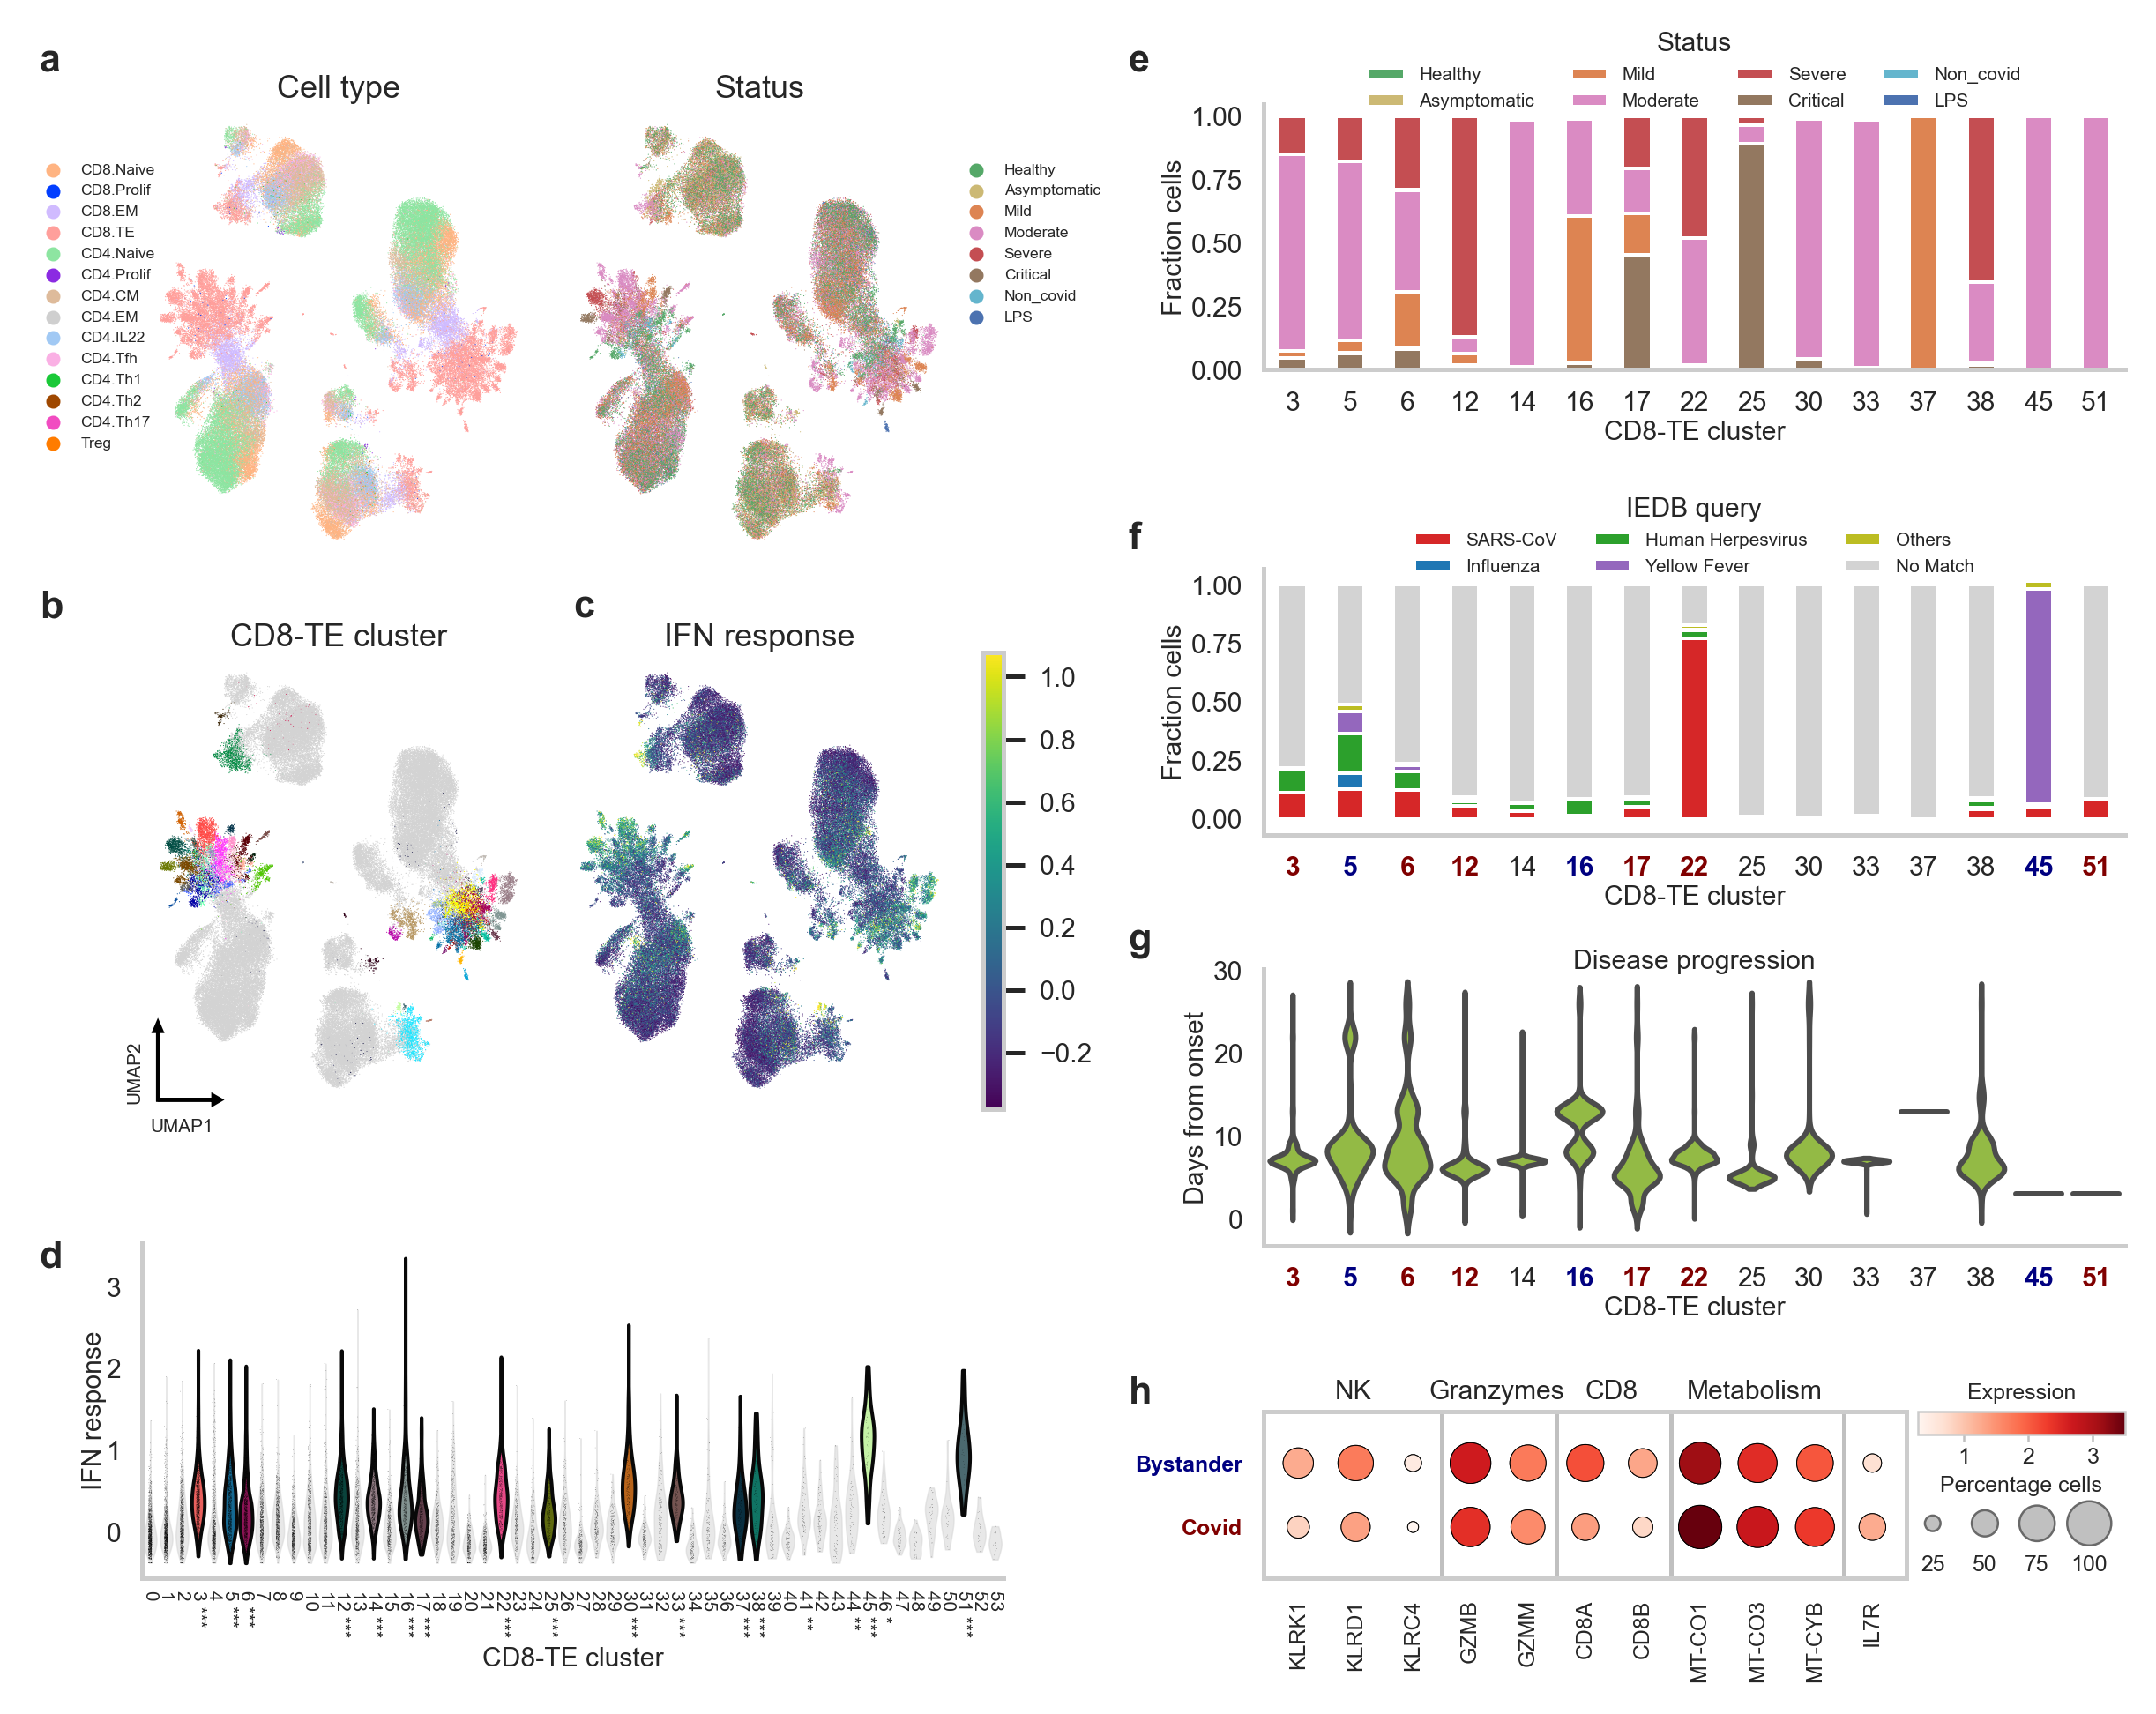

In [24]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.8),
                 dpi=DPI)
gridspecs = {}

#aa c
#aa d   
#b  e  
#   f

# a=UMAPs, b=violin ifn score, c=status, d=db query, e=days from onset, f=degs


gridspecs["gs_abcdef"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    #wspace=0.1,
    #left=0.00,
    #right=1,
    #top=1,
    #bottom=0,
)

gridspecs["gs_ab"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_abcdef"][0],
    nrows=2,
    ncols=1,
    height_ratios=[3, 1],
    width_ratios=[1],
)

gridspecs["gs_a"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_ab"][0],
    nrows=2,
    ncols=3,
    height_ratios=[1, 1],
    width_ratios=[1, 1, 0.05],
    wspace=0.1
)


gridspecs["gs_cdef"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_abcdef"][1],
    nrows=2,
    ncols=1,
    height_ratios=[1.2, 1],
    width_ratios=[1],
    #hspace=0.5
)

gridspecs["gs_cd"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_cdef"][0],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1],
    width_ratios=[1],
    hspace=0.75
)

gridspecs["gs_ef"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_cdef"][1],
    nrows=2,
    ncols=1,
    height_ratios=[1, 0.6],
    width_ratios=[1],
    hspace=0.75
)

"""gridspecs["gs_f"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_ef"][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
)"""

ax_a = {}
for i in range(6):
    ax_a[i] = fig.add_subplot(gridspecs["gs_a"][i])


ax_b = fig.add_subplot(gridspecs["gs_ab"][1])

ax_c = fig.add_subplot(gridspecs["gs_cd"][0])
ax_d = fig.add_subplot(gridspecs["gs_cd"][1])
ax_e = fig.add_subplot(gridspecs["gs_ef"][0])

#ax_f = fig.add_subplot(gridspecs["gs_ef"][1])
#ax_f1 = fig.add_subplot(gridspecs["gs_f"][0])
#ax_f2 = fig.add_subplot(gridspecs["gs_f"][1])

plot_umap(adata, 'full_clustering', ax_a[0], xlabel='Cell type', legend='upper left', order=order_ct)
plot_umap(adata, 'Status_on_day_collection_summary', ax_a[1], xlabel='Status', legend='upper right', order=order_status)
plot_empty(ax_a[2])

plot_umap(adata, 'leiden_moe_cd8te', ax_a[3], xlabel='CD8-TE cluster')
plot_umap(adata, 'ifn response_score', ax_a[4], xlabel='IFN response')
plot_colorbar(adata, 'ifn response_score', ax_a[5])

plot_umap_axis(ax_a[3], offset=0.05)

plot_violin(adata, 'ifn response_score', ax_b)
plot_stacked_bar(df_status, 'Status', 'Fraction cells',  palette_status, ax_c, legend=True, order=order_status)

cv_clusters = ['3', '6', '12', '17', '22', '51']
by_clusters = ['5', '16',  '45']
plot_stacked_bar(df_disease, 'IEDB query', 'Fraction cells', palette_query, ax_d, legend=True, order=order_disease,
                cv_clusters=cv_clusters, by_clusters=by_clusters)

plot_days(adata, 'days_from_onset_numeric', ax_e,
         cv_clusters=cv_clusters, by_clusters=by_clusters)
#plot_degs('Bystander', ax_f1, left=True)
#plot_degs('Covid', ax_f2)

genes = ['KLRK1', 'KLRD1', 'KLRC4', 
         'GZMB', 'GZMM',
         'CD8A', 'CD8B', 
         'MT-CO1', 'MT-CO3', 'MT-CYB', 
         'IL7R']#, '' 'IL7R', 'GNLY', 'NCR3', 'GZMK']
labels = ['NK', 'Granzymes', 'CD8', 'Metabolism']#, 'tbd']
positions = [[1, 1], [3, 4], [5, 6], [8, 8]]
seperators = [3, 5, 7, 10]
plot_degs_dotplot(gridspecs["gs_ef"][1], genes, labels, positions, seperators, size=100, pos1=2.5, pos2=8.5)


fig.text(0.01, 0.96, 'a', size='x-large', weight='bold')
fig.text(0.01, 0.64, 'b', size='x-large', weight='bold')
fig.text(0.26, 0.64, 'c', size='x-large', weight='bold')
fig.text(0.01, 0.26, 'd', size='x-large', weight='bold')
fig.text(0.52, 0.96, 'e', size='x-large', weight='bold')
fig.text(0.52, 0.68, 'f', size='x-large', weight='bold')
fig.text(0.52, 0.445, 'g', size='x-large', weight='bold')
fig.text(0.52, 0.18, 'h', size='x-large', weight='bold')


fig.tight_layout()
fig.savefig('../figures/03_haniffa_dp.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/03_haniffa_dp.png',
           dpi=DPI, bbox_inches='tight')

## Supplementary data SXYZ

In [25]:
content = {}

multi_index = []
for group in ['Bystander', 'Covid']:
    idx = np.logical_and(adata.uns['rank_genes_groups']['pvals_adj'][group] <=0.05,
                         adata.uns['rank_genes_groups']['logfoldchanges'][group] >=0.25)
    for info in ['names', 'scores', 'pvals_adj', 'logfoldchanges']:
        content[f'{group}_{info}'] = adata.uns['rank_genes_groups'][info][group][idx].tolist()
        
        info_tmp = info if info!='names' else 'genes'
        multi_index.append((group, info_tmp))

max_len = max([len(col) for col in content.values()])
for k, v in content.items():
    content[k] = v + [''] * (max_len-len(v))

multi_index = pd.MultiIndex.from_tuples(multi_index)
        
df_gene_ranking = pd.DataFrame(data=content)
df_gene_ranking = pd.DataFrame(df_gene_ranking.values, columns=multi_index)
df_gene_ranking.to_csv('../results/fig02_haniffa_degs.csv')
df_gene_ranking.head()

Bystander                                       Covid                       \
      genes     scores pvals_adj logfoldchanges   genes     scores pvals_adj   
0      CD8A  17.717047       0.0       1.293517    IL7R  14.803314       0.0   
1      CD8B  15.039758       0.0       1.182096  MT-CO1  12.391533       0.0   
2    FCGR3A  13.913212       0.0       1.286293   KLRB1  10.835088       0.0   
3     KLRK1  12.279676       0.0       0.901962  MT-ND3   7.557959       0.0   
4      CTSW  11.033748       0.0       0.570761  S100A8   7.460617       0.0   

                  
  logfoldchanges  
0       1.345192  
1        0.56025  
2       1.541781  
3       0.569038  
4       0.697668

## Supplementary Figure 1

C:\Users\FELIX~1.DRO\AppData\Local\Temp/ipykernel_15456/995858790.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


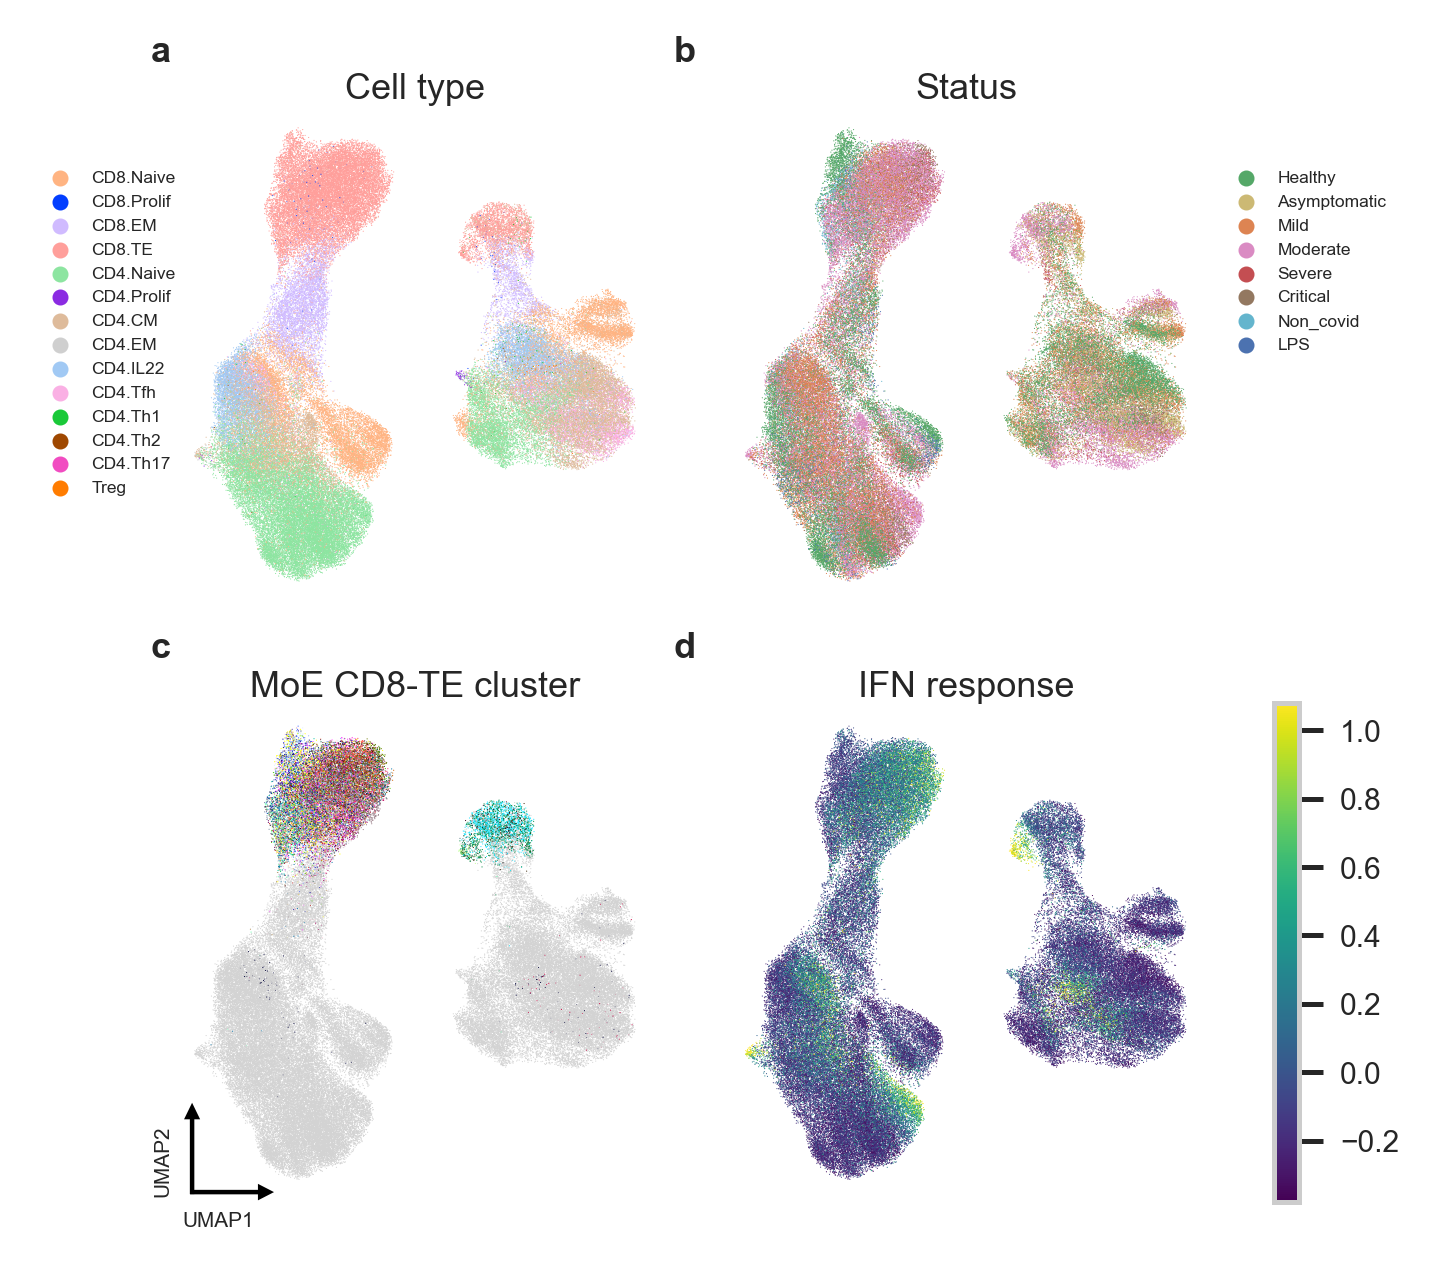

In [26]:
fig = plt.figure(figsize=(TEXT_WIDTH * 0.6, TEXT_WIDTH * 0.6),
                 dpi=DPI)
gridspecs = {}

#ab
#cd 


gridspecs["gs_a"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=3,
    height_ratios=[1, 1],
    width_ratios=[1, 1, 0.05],
    wspace=0.2
)

ax_a = {}
for i in range(6):
    ax_a[i] = fig.add_subplot(gridspecs["gs_a"][i])

    
plot_umap(adata, 'full_clustering', ax_a[0], xlabel='Cell type', legend='upper left', order=order_ct, embedding='rna')
plot_umap(adata, 'Status_on_day_collection_summary', ax_a[1], xlabel='Status', legend='upper right', order=order_status, 
          embedding='rna')
plot_empty(ax_a[2])

plot_umap(adata, 'leiden_moe_cd8te', ax_a[3], xlabel='MoE CD8-TE cluster', embedding='rna')
plot_umap(adata, 'ifn response_score', ax_a[4], xlabel='IFN response', embedding='rna')
plot_colorbar(adata, 'ifn response_score', ax_a[5])

plot_umap_axis(ax_a[3], offset=0.05)

fig.text(0.11, 0.91, 'a', size='large', weight='bold')
fig.text(0.47, 0.91, 'b', size='large', weight='bold')
fig.text(0.11, 0.50, 'c', size='large', weight='bold')
fig.text(0.47, 0.50, 'd', size='large', weight='bold')

fig.tight_layout()
fig.savefig('../figures/s04_haniffa.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/s04_haniffa.png',
           dpi=DPI, bbox_inches='tight')

## Stats

### Days after Onset Reactive clusters

In [27]:
adata[adata.obs['leiden_moe_cd8te'].isin(react_leiden)].obs.groupby('leiden_moe_cd8te')['days_from_onset_numeric'].mean()

leiden_moe_cd8te
3      7.439962
5      9.477296
6      9.462793
12     6.735549
14     6.961479
16    11.318083
17     6.295711
22     7.642317
25     5.519481
30     8.528497
33     6.950355
37    13.000000
38     7.663366
45     3.000000
51     3.000000
Name: days_from_onset_numeric, dtype: float64

In [28]:
adata[adata.obs['leiden_moe_cd8te'].isin(react_leiden)].obs['days_from_onset_numeric'].mean()

8.096052034487975

In [29]:
adata[adata.obs['leiden_moe_cd8te'].isin(react_leiden)].obs['days_from_onset_numeric'].std()

3.9608142425720274

### Days after Onset Non-Reactive clusters

In [30]:
adata[~adata.obs['leiden_moe_cd8te'].isin(react_leiden)].obs['days_from_onset_numeric'].mean()

11.761844398668991

In [31]:
adata[~adata.obs['leiden_moe_cd8te'].isin(react_leiden)].obs['days_from_onset_numeric'].std()

8.882912271067822

### Days after Onset - Covid clusters

In [32]:
adata[adata.obs['leiden_moe_cd8te'].isin(cv_clusters)].obs.groupby('leiden_moe_cd8te')['days_from_onset_numeric'].mean()

leiden_moe_cd8te
3     7.439962
6     9.462793
12    6.735549
17    6.295711
22    7.642317
51    3.000000
Name: days_from_onset_numeric, dtype: float64

In [33]:
adata[adata.obs['leiden_moe_cd8te'].isin(cv_clusters)].obs['days_from_onset_numeric'].mean()

7.708772903942254

In [34]:
adata[adata.obs['leiden_moe_cd8te'].isin(cv_clusters)].obs['days_from_onset_numeric'].std()

3.7539390688575156

### Days after Onset - Bystander clusters

In [35]:
adata[adata.obs['leiden_moe_cd8te'].isin(by_clusters)].obs.groupby('leiden_moe_cd8te')['days_from_onset_numeric'].mean()

leiden_moe_cd8te
5      9.477296
16    11.318083
45     3.000000
Name: days_from_onset_numeric, dtype: float64

In [36]:
adata[adata.obs['leiden_moe_cd8te'].isin(by_clusters)].obs['days_from_onset_numeric'].mean()

9.770502645502646

In [37]:
adata[adata.obs['leiden_moe_cd8te'].isin(by_clusters)].obs['days_from_onset_numeric'].std()

4.909866915614528

###  Days after Onset - Bystander clusters

In [38]:
adata[~adata.obs['leiden_moe_cd8te'].isin(by_clusters) 
      & ~adata.obs['leiden_moe_cd8te'].isin(cv_clusters) 
     ].obs['days_from_onset_numeric'].mean()

11.66843396598889

### Amount cells expressing

In [39]:
adata_cv = adata[adata.obs['leiden_moe_cd8te'].isin(cv_clusters)]
adata_il7r_cv = adata_cv[adata_cv[:, 'IL7R'].X>0]
len(adata_il7r_cv)/len(adata_cv)

0.3087136929460581